In [79]:
import numpy as np
import dxchange
import matplotlib.pyplot as plt
import cupy as cp
import scipy.ndimage as ndimage
import numpy as np
import sys
from matplotlib_scalebar.scalebar import ScaleBar
%matplotlib inline

In [80]:
n = 256  # object size in each dimension

ntheta = 360  # number of angles (rotations)
noise = 0
z1c = -12e-3
# thickness of the coded aperture
code_thickness = 1.5e-6 #in m
# feature size
ill_feature_size = 1e-6 #in m

# ntheta = int(sys.argv[1])  # number of angles (rotations)
# noise = int(sys.argv[2])#sys.argv[2]=='True'
# z1c = float(sys.argv[3])  # positions of the code and the probe for reconstruction


center = n/2 # rotation axis
theta = cp.linspace(0, np.pi, ntheta,endpoint=False).astype('float32')  # projection angles
npos = 1  # number of code positions
detector_pixelsize = 3e-6/2
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = 4.584e-3-sx0# np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:npos]-sx0
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

# magnification when propagating from the probe plane to the detector
magnifications2 = np.abs(z1/z1c)
distances2 = (z1-z1c)/(z1c/z1)#magnifications2
# allow padding if there are shifts of the probe
pad = n//8
# sample size after demagnification
ne = n+2*pad

show = True

flg = f'{n}_{ntheta}_{npos}_{z1c}_{noise}_code'
# print(magnifications2,norm_magnifications)
# print(distances2,distances22)

2266216.594128324
0.0014628546560803157
0.0014343146
0.0014001556
0.0014149523
0.0014625805


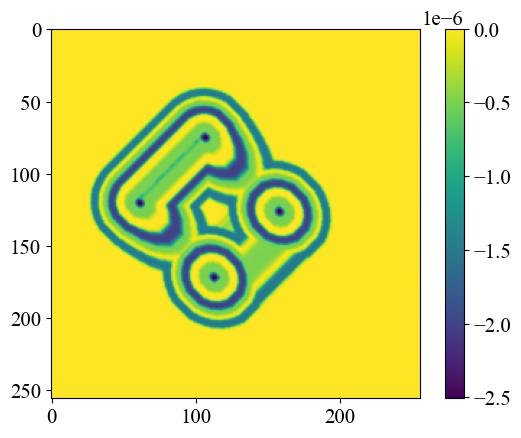

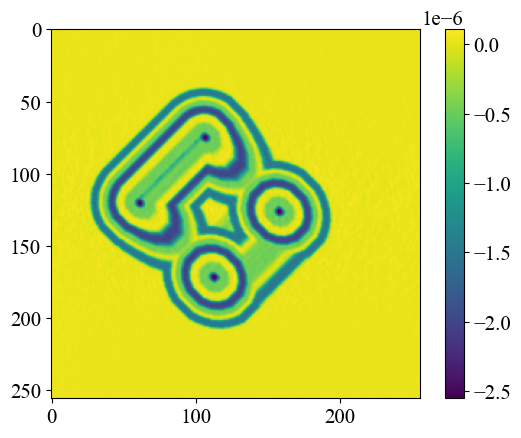

In [81]:

u00 = np.load('data/u.npy').real
u = {}
conv ={}
step = {}
c = voxelsize * 2*cp.pi / wavelength*np.sqrt(ne*ntheta)
print(c)
niter = 512
print(np.linalg.norm(u00))
for k in {'cghessians','gradhessians2','daihessians'}:
    u[f'{k}'] = np.load(f'data/u_{k}_{niter}.npy')[32:-32,32:-32,32:-32].real/c
    print(np.linalg.norm( u[f'{k}']))
    conv[f'{k}'] = np.load(f'data/conv_{k}.npy')[:niter]
    step[f'{k}'] = np.load(f'data/step_{k}.npy')[:niter]

for k in {'admmline'}:
    u[f'{k}'] = np.load(f'data/u_{k}_{niter}.npy')[32:-32,32:-32,32:-32].real#*3/2
    u[f'{k}'] = u[f'{k}']*np.linalg.norm(u00)/np.linalg.norm( u[f'{k}'])
    print(np.linalg.norm( u[f'{k}']))
    conv[f'{k}'] = np.load(f'data/conv_{k}.npy')[:niter]
    step[f'{k}'] = np.load(f'data/step_{k}.npy')[:niter]
    conv[f'{k}'][0] = conv[f'gradhessians2'][0]

plt.figure()
plt.imshow(u00[:,128])
plt.colorbar()
plt.figure()
plt.imshow(u[f'cghessians'][:,128].real)
plt.colorbar()

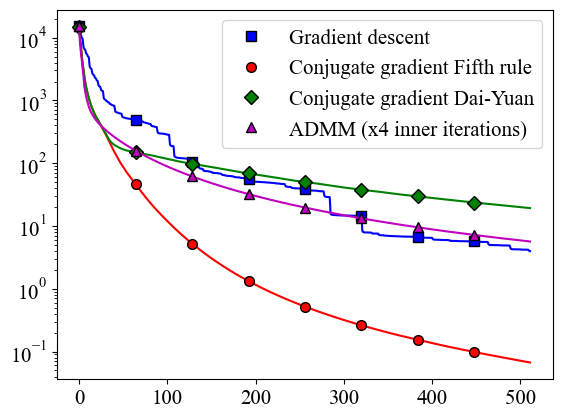

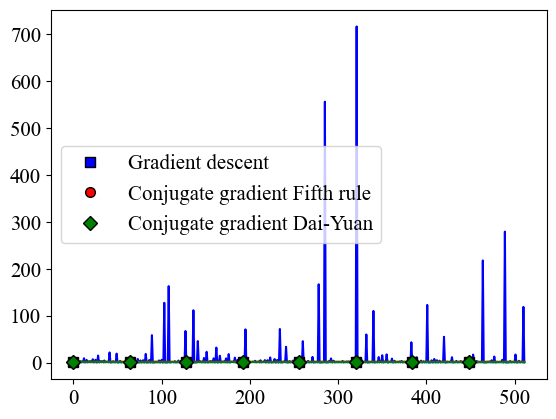

In [82]:

import matplotlib.pyplot as plt
import numpy as np
import pickle

import matplotlib
font = {'family' : 'Times New Roman', 'size'   : 15}
matplotlib.rc('font', **font)
from matplotlib.ticker import FormatStrFormatter

step2 = 1
x = np.arange(0,len(conv['gradhessians2']),step2)


xstep = 64

fig, ax = plt.subplots()

ax.plot(x,conv['gradhessians2'],'-',color='b')
ax.plot(x[::xstep],conv['gradhessians2'][::xstep],'s',color='b',ms=7,mec='black',label='Gradient descent')
ax.plot(x,conv['cghessians'],'-',color='r')
ax.plot(x[::xstep],conv['cghessians'][::xstep],'o',color='r',ms=7,mec='black',label='Conjugate gradient Fifth rule')
ax.plot(x,conv['daihessians'],'-',color='g')
ax.plot(x[::xstep],conv['daihessians'][::xstep],'D',color='g',ms=7,mec='black',label='Conjugate gradient Dai-Yuan')
ax.plot(x,conv['admmline'],'-',color='m')
ax.plot(x[::xstep],conv['admmline'][::xstep],'^',color='m',ms=7,mec='black',label='ADMM (x4 inner iterations)')


ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax.set_yscale('log')
ax.legend()
plt.savefig(f'figs/conv_holo.png',dpi=300,bbox_inches='tight')
fig, ax = plt.subplots()

ax.plot(x,step['gradhessians2'],'-',color='b')
ax.plot(x[::xstep],step['gradhessians2'][::xstep],'s',color='b',ms=7,mec='black',label='Gradient descent')
ax.plot(x,step['cghessians'],'-',color='r')
ax.plot(x[::xstep],step['cghessians'][::xstep],'o',color='r',ms=7,mec='black',label='Conjugate gradient Fifth rule')
ax.plot(x,step['daihessians'],'-',color='g')
ax.plot(x[::xstep],step['daihessians'][::xstep],'D',color='g',ms=7,mec='black',label='Conjugate gradient Dai-Yuan')
# ax.plot(x,conv['admmline'],'-',color='g')
# ax.plot(x[::xstep],conv['admmline'][::xstep],'^',color='g',ms=7,mec='black',label='ADMM (x4 inner iterations)')

# ax.set_ylim([0,7])
ax.legend()
plt.savefig(f'figs/step_holo.png',dpi=300,bbox_inches='tight')


In [83]:
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
vvmin = -3e-7
vvmax = 2.4e-6
u0 = u00[:,128+3]
def mshow(a,**args):
    aa=a.copy()
    aa[0,0]=vvmin
    aa[0,1]=vvmax
    plt.imshow(aa,**args)
c=1
def mshowfull(u):
    fig, ax = plt.subplots(figsize=(3,3))
    shape = u.shape
    im = ax.imshow(-u[shape[0]//2-128:shape[0]//2+128,shape[1]//2-128:shape[1]//2+128],cmap='gray',vmax=vvmax,vmin=vvmin)
    scalebar = ScaleBar(voxelsize, "m", length_fraction=0.25, font_properties={
            "family": "serif",
        },  # For more information, see the cell below
        location="lower right")
    ax.add_artist(scalebar)
    # ax.tick_params(axis='both', which='major', labelsize=11)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=12)
    uu = -u[shape[0]//2-128:shape[0]//2+128,shape[1]//2-128:shape[1]//2+128]
    ins_ax = ax.inset_axes([0.5, 0.5, .5, .5])  # [x, y, width, height] w.r.t. ax
    uu = uu[50:102,80:132]
    uu[:,:1] = vvmax
    uu[-1:,:] = vvmax
    uu[0,0] = vvmin
    
    ins_ax.imshow(uu,cmap='gray',vmax=vvmax,vmin=vvmin)
    ins_ax.axis('off')
    a = -u[shape[0]//2-128:shape[0]//2+128,shape[1]//2-128:shape[1]//2+128]
    b = -u0
    mssim = np.linalg.norm(a[c:-c,c:-c]-b[c:-c,c:-c])/np.linalg.norm(b[c:-c,c:-c])
    if mssim>0.001:
        ax.text(5,250,f'error: {mssim:.3f}',fontsize=19,color='white')

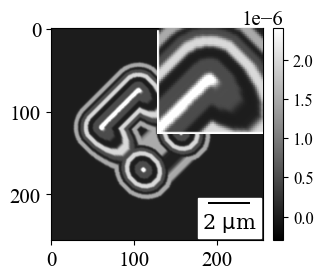

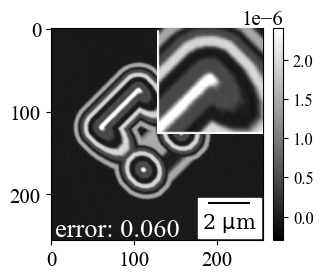

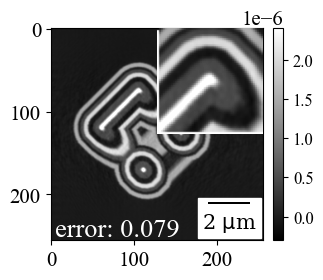

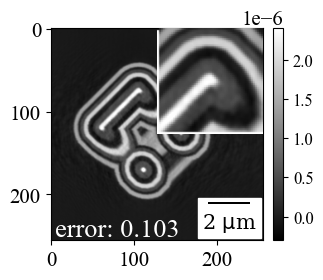

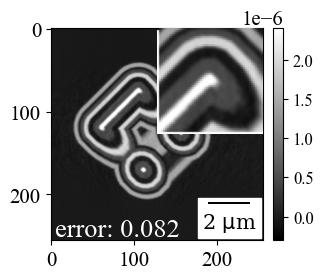

In [84]:

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error


mshowfull(u00[:,128+3])
plt.savefig(f'figs/u.png',dpi=300,bbox_inches='tight')

for k in {'gradhessians2','cghessians','admmline','daihessians'}:
    mshowfull(u[f'{k}'][:,128+3])
    plt.savefig(f'figs/u_{k}_{niter}.png',dpi=300,bbox_inches='tight')

In [85]:
import skimage
z1c = -0.012  # positions of the code and the probe for reconstruction
u = np.load('data/u.npy').real
noise = 1999
rec_c = {}
conv_c2 = {}
for na in [180,360,540]:
    flg = f'{n}_{na}_{1}_{z1c}_{noise}_code'
    print(f'/data2/vnikitin/coded_apertures_new3/u_{flg}/{m:03}.tiff')
    rec_c[f'{na}'] = dxchange.read_tiff(f'/data2/vnikitin/coded_apertures_new3/u_{flg}/{m:03}.tiff')
    print(rec_c[f'{na}'].shape)
    conv_c2[f'{na}'] = []#np.zeros((m-64)//32+64)#np.load(f'/data2/vnikitin/coded_apertures_new3/conv_{flg}.npy')
    # b = np.zeros([256,256],dtype='float32')
    u0=rec_c[f'{na}'] = dxchange.read_tiff(f'/data2/vnikitin/coded_apertures_new3/u_{flg}/{0:03}.tiff')
    for k in [*range(0,64),*range(64,m,32)]:
        rec_c[f'{na}'] = dxchange.read_tiff(f'/data2/vnikitin/coded_apertures_new3/u_{flg}/{k:03}.tiff')
        shape = rec_c[f'{na}'].shape
        a = -rec_c[f'{na}'][shape[0]//2-128:shape[0]//2+128,shape[1]//2-128:shape[1]//2+128]
        b = -u0[shape[0]//2-128:shape[0]//2+128,shape[1]//2-128:shape[1]//2+128]#-u[:,u.shape[1]//2+3]
        # conv_c[f'{na}'].append(skimage.metrics.peak_signal_noise_ratio(b[c:-c,c:-c], a[c:-c,c:-c],data_range=b.max()-b.min()))
        conv_c2[f'{na}'].append(np.linalg.norm(a[c:-c,c:-c]-b[c:-c,c:-c])/np.linalg.norm(b[c:-c,c:-c]))
        # conv_c[f'{na}'].append(np.linalg.norm(a[c:-c,c:-c]-b[c:-c,c:-c]))
        # b = a.copy() 
    # conv_c[f'{na}'][0] = conv_c[f'{na}'][1]

z1p = 4.21e-03
rec = {}
conv2 = {}
# flg = f'{n}_{180}_{1}_{z1p:.2e}_conv'
for na in [1,2,3]:
    flg = f'{n}_{180}_{na}_{z1p:.2e}_{noise}_conv'
    # flg = f'{n}_{180}_{na}_{z1p:.2e}_conv'
    print(f'/data2/vnikitin/coded_apertures_new3/u_{flg}/{m:03}.tiff')
    rec[f'{na}'] = dxchange.read_tiff(f'/data2/vnikitin/coded_apertures_new3/u_{flg}/{m:03}.tiff')
    conv2[f'{na}'] = []#np.zeros((m-64)//32+64)#np.load(f'/data2/vnikitin/coded_apertures_new3/conv_{flg}.npy')
    u0 = -rec[f'{na}'][shape[0]//2-128:shape[0]//2+128,shape[1]//2-128:shape[1]//2+128]
    # b = np.zeros([256,256],dtype='float32')
    for k in [*range(0,64),*range(64,m,32)]:
        rec[f'{na}'] = dxchange.read_tiff(f'/data2/vnikitin/coded_apertures_new3/u_{flg}/{k:03}.tiff')
        shape = rec[f'{na}'].shape    
        a = -rec[f'{na}'][shape[0]//2-128:shape[0]//2+128,shape[1]//2-128:shape[1]//2+128]
        #a = -rec[f'{na}'][shape[0]//2-128:shape[0]//2+128,shape[1]//2-128:shape[1]//2+128]
        b = -u0[shape[0]//2-128:shape[0]//2+128,shape[1]//2-128:shape[1]//2+128]#-u[:,u.shape[1]//2+3]
        # conv[f'{na}'].append(skimage.metrics.peak_signal_noise_ratio(b[c:-c,c:-c], a[c:-c,c:-c],data_range=b.max()-b.min()))
        conv2[f'{na}'].append(np.linalg.norm(a[c:-c,c:-c]-b[c:-c,c:-c])/np.linalg.norm(b[c:-c,c:-c]))
        # conv[f'{na}'].append(np.linalg.norm(a[c:-c,c:-c]-b[c:-c,c:-c]))
        # b = a.copy() 
    # conv[f'{na}'][0] = conv[f'{na}'][1]



NameError: name 'm' is not defined

In [ ]:

import matplotlib
font = {'family' : 'Times New Roman', 'size'   : 13}
matplotlib.rc('font', **font)
x = np.array([*range(0,64),*range(64,m,32)])
plt.plot(x,conv2['1'][:],'-',color='b')
plt.plot(x[:64:32],conv2['1'][:64:32],'s',color='b')
plt.plot(x[64::2],conv2['1'][64::2],'s',color='b',label='Multi-distance, 1 dist, 180 angles')

plt.plot(x,conv2['2'][:],'-',color='b')
plt.plot(x[:64:32],conv2['2'][:64:32],'o',color='b')
plt.plot(x[64::2],conv2['2'][64::2],'o',color='b',label='Multi-distance, 2 dist, 180 angles')

plt.plot(x,conv2['3'][:],'-',color='b')
plt.plot(x[:64:32],conv2['3'][:64:32],'^',color='b')
plt.plot(x[64::2],conv2['3'][64::2],'^',color='b',label='Multi-distance, 3 dist, 180 angles')

plt.plot(x,conv_c2['180'][:],'-',color=(1, 0, 0))
plt.plot(x[:64:32],conv_c2['180'][:64:32],'s',color=(1, 0, 0))
plt.plot(x[64::2],conv_c2['180'][64::2],'s',color=(1, 0, 0),label='Coded aperture, 1 dist, 180 angles')

plt.plot(x,conv_c2['360'][:],'-',color=(1, 0, 0))
plt.plot(x[:64:32],conv_c2['360'][:64:32],'o',color=(1, 0, 0))
plt.plot(x[64::2],conv_c2['360'][64::2],'o',color=(1, 0, 0),label='Coded aperture, 1 dist, 360 angles')

plt.plot(x,conv_c2['540'][:],'-',color=(1, 0, 0))
plt.plot(x[:64:32],conv_c2['540'][:64:32],'^',color=(1, 0, 0))
plt.plot(x[64::2],conv_c2['540'][64::2],'^',color=(1, 0, 0),label='Coded aperture, 1 dist, 540 angles')

plt.ylim([0.05,0.6])

# plt.ylim([0.05,0.45])
# plt.xlim([0,65])
# plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.savefig(f'figs/noise{noise}.png',dpi=300,bbox_inches='tight')


In [ ]:

import matplotlib
font = {'family' : 'Times New Roman', 'size'   : 13}
matplotlib.rc('font', **font)
x = np.array([*range(0,64),*range(64,m,32)])

plt.plot(x,conv['1'][:],'-',color='b')
plt.plot(x[:64:32],conv['1'][:64:32],'s',color='b')
plt.plot(x[64::2],conv['1'][64::2],'s',color='b',label='Multi-distance, 1 dist, 180 angles')

plt.plot(x,conv['2'][:],'-',color='b')
plt.plot(x[:64:32],conv['2'][:64:32],'o',color='b')
plt.plot(x[64::2],conv['2'][64::2],'o',color='b',label='Multi-distance, 2 dist, 180 angles')

plt.plot(x,conv['3'][:],'-',color='b')
plt.plot(x[:64:32],conv['3'][:64:32],'^',color='b')
plt.plot(x[64::2],conv['3'][64::2],'^',color='b',label='Multi-distance, 3 dist, 180 angles')

plt.plot(x,conv2['3'][:],'--',color=(0, 0, 1))
plt.plot(x[:64:32],conv2['3'][:64:32],'d',color=(0, 0, 1))
plt.plot(x[64::2],conv2['3'][64::2],'d',color=(0, 0, 1),label='Multi-distance, 3 dist, 180 angles, noise')

plt.plot(x,conv_c['180'][:],'-',color=(1, 0, 0))
plt.plot(x[:64:32],conv_c['180'][:64:32],'s',color=(1, 0, 0))
plt.plot(x[64::2],conv_c['180'][64::2],'s',color=(1, 0, 0),label='Coded aperture, 1 dist, 180 angles')

plt.plot(x,conv_c['360'][:],'-',color=(1, 0, 0))
plt.plot(x[:64:32],conv_c['360'][:64:32],'o',color=(1, 0, 0))
plt.plot(x[64::2],conv_c['360'][64::2],'o',color=(1, 0, 0),label='Coded aperture, 1 dist, 360 angles')

plt.plot(x,conv_c['540'][:],'-',color=(1, 0, 0))
plt.plot(x[:64:32],conv_c['540'][:64:32],'^',color=(1, 0, 0))
plt.plot(x[64::2],conv_c['540'][64::2],'^',color=(1, 0, 0),label='Coded aperture, 1 dist, 540 angles')

plt.plot(x,conv_c2['360'][:],'--',color=(1, 0, 0))
plt.plot(x[:64:32],conv_c2['360'][:64:32],'d',color=(1, 0, 0))
plt.plot(x[64::2],conv_c2['360'][64::2],'d',color=(1, 0, 0),label='Coded aperture, 1 dist, 360 angles, noise')



plt.ylim([0.085,0.56])
# plt.xlim([0,65])
# plt.yscale('log')
# plt.xscale('log')
plt.legend(fontsize=12,loc='upper right')
plt.savefig(f'figs/noise{noise}.png',dpi=300,bbox_inches='tight')


In [ ]:

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

mshowfull(u[:,128+3])
plt.savefig(f'figs/u.png',dpi=300,bbox_inches='tight')

for na in [180,360,540]:
    mshowfull(rec_c[f'{na}'])
    plt.savefig(f'figs/rec_cn_{na}.png',dpi=300,bbox_inches='tight')
for na in [1,2,3]:
    mshowfull(rec[f'{na}'])
    plt.savefig(f'figs/recn_{na}.png',dpi=300,bbox_inches='tight')